# Flight Price Prediction

In [213]:
# Import necessary libraries
import pandas as pd
import numpy as np

In [214]:
# Load the dataset
df = pd.read_csv("flight.csv")

In [215]:
# Inspect the dataset
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## EDA

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [217]:
df['stops'].unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [218]:
numerical = ['duration', 'days_left']
categorical = list(df.dtypes[df.dtypes == 'object'].index)

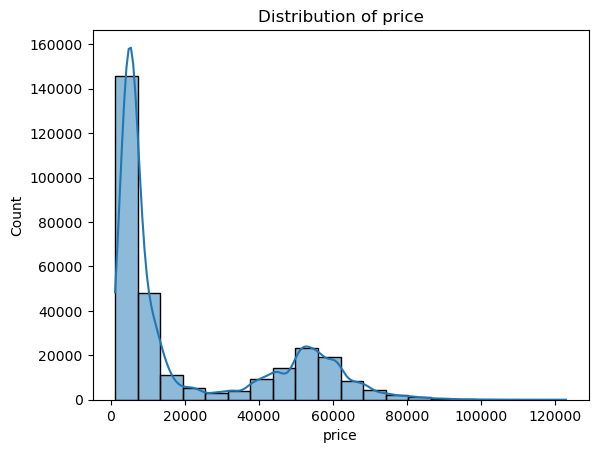

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["price"], kde=True, bins=20)
plt.title(f'Distribution of price')
plt.show()

In [220]:
df.price.describe()

count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

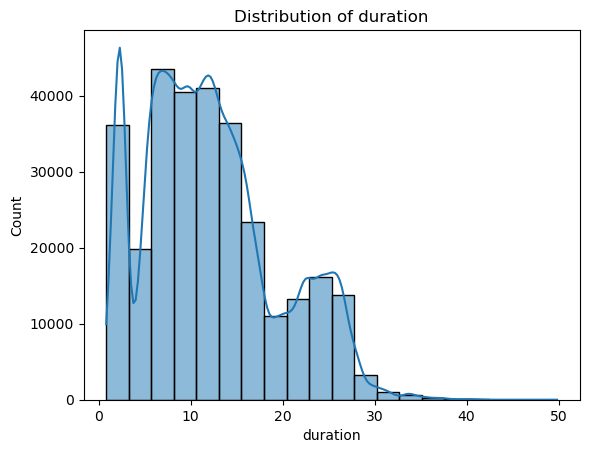

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["duration"], kde=True, bins=20)
plt.title(f'Distribution of duration')
plt.show()

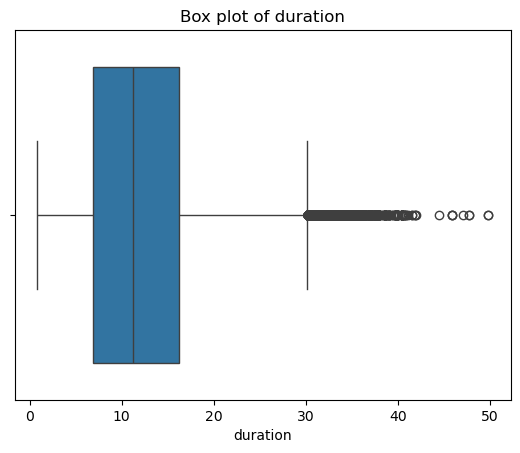

In [44]:
sns.boxplot(x=df["duration"])
plt.title(f'Box plot of duration')
plt.show()

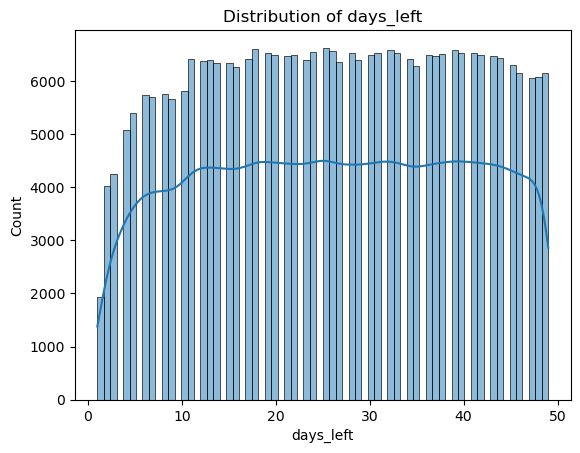

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["days_left"], kde=True)
plt.title(f'Distribution of days_left')
plt.show()

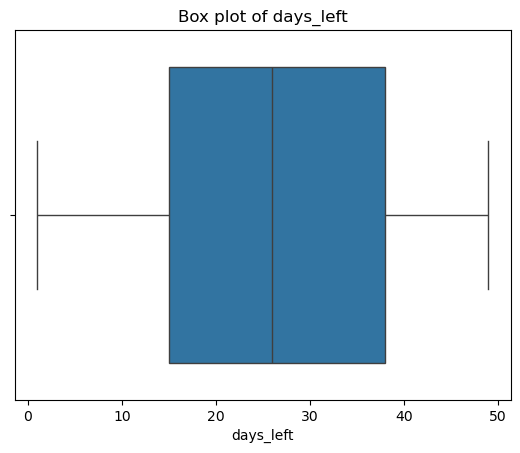

In [46]:
sns.boxplot(x=df["days_left"])
plt.title(f'Box plot of days_left')
plt.show()

In [47]:
df["days_left"].nunique()

49

In [48]:
for column in categorical:
    print(df[column].value_counts())
    print()
    print(f"unique values of {column}: {df[column].nunique()}")
    print()

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

unique values of airline: 6

flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: count, Length: 1561, dtype: int64

unique values of flight: 1561

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

unique values of source_city: 6

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

unique values of departure_time: 6

stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

unique values of stops: 3

arrival_time
Night            915

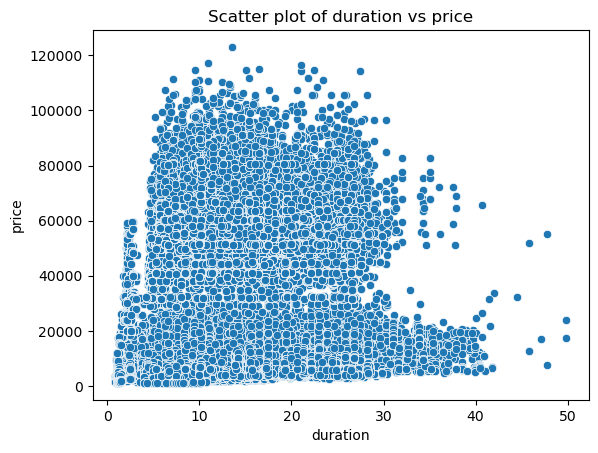

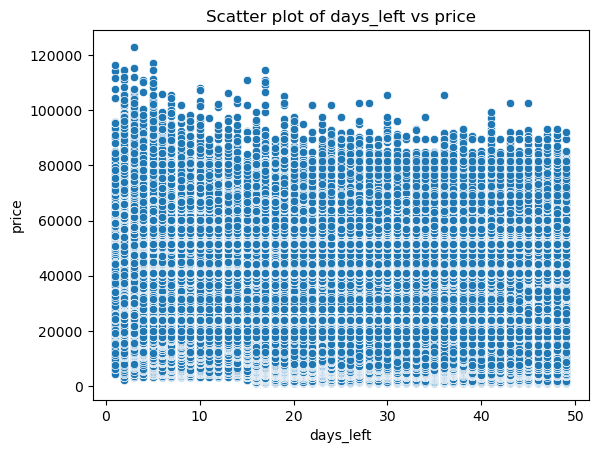

In [49]:
for column in df.drop('price', axis=1)[numerical]: 
    sns.scatterplot(x=df[column], y=df['price'])
    plt.title(f'Scatter plot of {column} vs price')
    plt.show()

In [50]:
df.price.describe()

count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

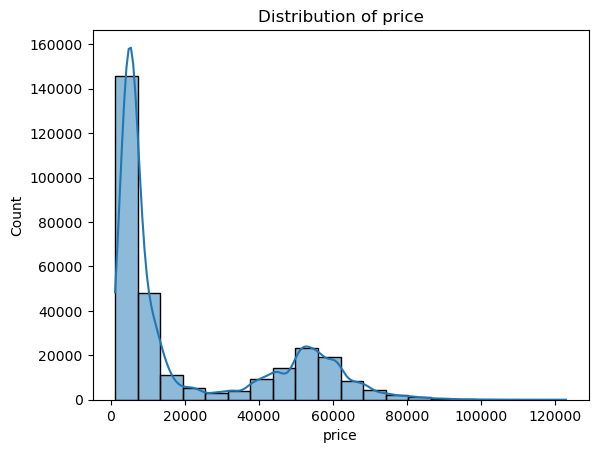

In [51]:
sns.histplot(df["price"], kde=True, bins=20)
plt.title(f'Distribution of price')
plt.show()

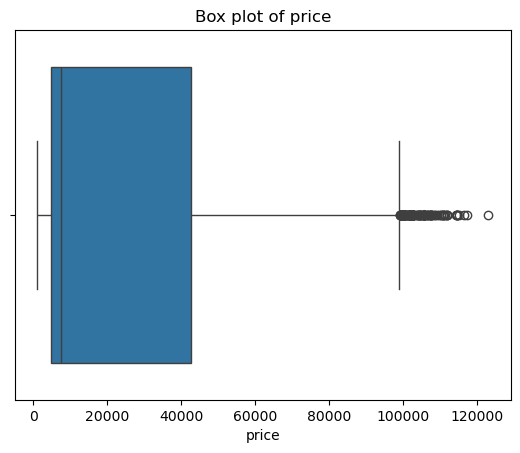

In [52]:
sns.boxplot(x=df["price"])
plt.title(f'Box plot of price')
plt.show()

## Data Preprocessing

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [211]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

def preprocess_data(
    df, target_column, categorical_columns,
    drop_columns=None, encode=True, log_columns=None,
    custom_features=None, outlier_removal=False
):
    """
    Modular preprocessing for data splitting, encoding, scaling, feature engineering, 
    and column-wise log transformation.

    Args:
    - df (DataFrame): The dataset.
    - target_column (str): Name of the target column.
    - categorical_columns (list): List of categorical columns to encode.
    - drop_columns (list): Columns to drop before training.
    - log_columns (list): List of columns to apply log-transform.

    Returns: The cleaned dataframe.
    """

    # Apply log transformation to specified columns
    if log_columns:
        for col in log_columns:
            if col in df.columns:
                df[col] = np.log1p(df[col])  # log1p to handle zero or near-zero values

    # Remove outliers
    if outlier_removal: 
        if 'price' in df.columns:
            df = df[df['price'] <= 100000]
            
        df = df[df['duration'] <= 30]
    
    # Drop specified columns
    if drop_columns:
        df = df.drop(columns=drop_columns)


    return df


In [181]:
# Initial necessary preprocessing
clean_df = preprocess_data(
    df=df, 
    target_column='price',
    categorical_columns=categorical,
    drop_columns=['Unnamed: 0']
)

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer


# Separate features and target
X = clean_df.drop(columns=['price'])  # Features
y = clean_df['price']                 # Target

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert training and validation data into dictionaries for DictVectorizer
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')

# Apply DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

## Training and Evaluation

In [108]:
# Train and evaluate models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def train_and_evaluate_models(models, X_train, y_train, X_val, y_val):
    """
    Train and evaluate multiple regression models.

    Args:
    - models (list): List of tuples containing model names and initialized model objects.
    - X_train (array-like): Training feature matrix.
    - y_train (array-like): Training target vector.
    - X_val (array-like): Validation feature matrix.
    - y_val (array-like): Validation target vector.

    Returns:
    - results_df (DataFrame): DataFrame summarizing model performance.
    """
    results = []

    for name, model in models:
        # Train the model
        model.fit(X_train, y_train)

        # Predict on validation set
        y_val_pred = model.predict(X_val)

        # Evaluate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2 = r2_score(y_val, y_val_pred)

        # Store results
        results.append({'Model': name, 'RMSE': rmse, 'R-squared': r2})

        print(f"Trained {name}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


## Model Selection

In [80]:
from xgboost import XGBRegressor

models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

In [58]:
train_and_evaluate_models(models, X_train, y_train, X_val, y_val)

Trained Linear Regression: RMSE = 747206953635.0421, R^2 = -1078566569248688.3750
Trained Ridge Regression: RMSE = 6228.4046, R^2 = 0.9251
Trained Random Forest: RMSE = 2522.4180, R^2 = 0.9877
Trained XGBoost: RMSE = 3506.0900, R^2 = 0.9763


,Model,RMSE,R-squared
0,Linear Regression,7.472070e+11,-1.078567e+15
1,Ridge Regression,6.228405e+03,9.250591e-01
2,Random Forest,2.522418e+03,9.877087e-01
3,XGBoost,3.506090e+03,9.762529e-01


### Go Back to Data

In [104]:
# Reducing skewness and bring the data distribution closer to normal
price_logs = np.log1p(df.price)
duration_logs = np.log1p(df.duration)

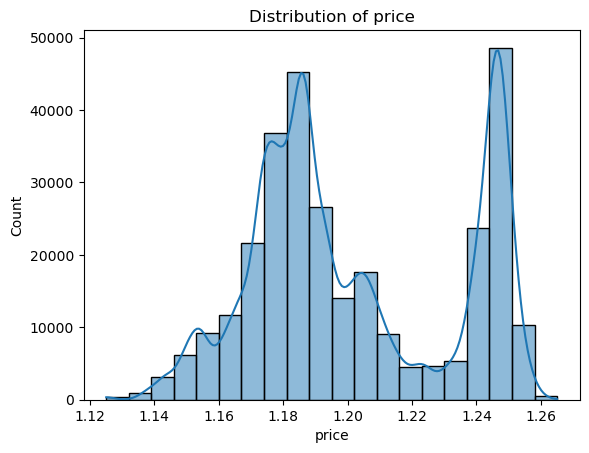

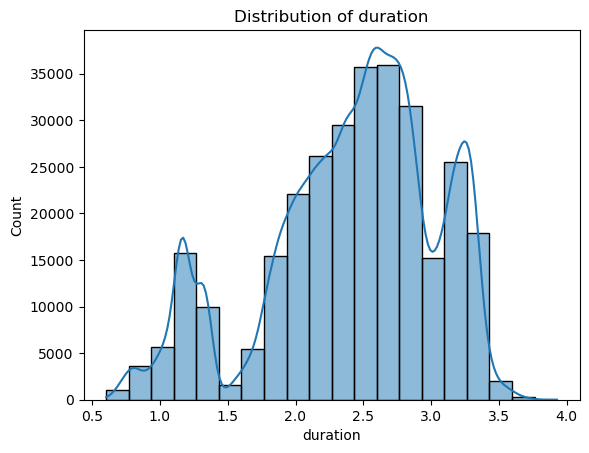

In [105]:
sns.histplot(price_logs, kde=True, bins=20)
plt.title(f'Distribution of price')
plt.show()

sns.histplot(duration_logs, kde=True, bins=20)
plt.title(f'Distribution of duration')
plt.show()

In [198]:
# Dropping  flight Column could improve model performance
# Since flight is likely a unique or near-unique identifier, it may not provide generalizable information for prediction.
# Log-transform the skewed columns to reduce skewness
categorical.remove('flight') 
clean_df = preprocess_data(df, 
                           target_column='price',
                           categorical_columns=categorical,
                           drop_columns=['Unnamed: 0', 'flight'],
                           log_columns=['duration', 'price'])

# Separate features and target
X = clean_df.drop(columns=['price'])  # Features
y = clean_df['price']                 # Target

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert training and validation data into dictionaries for DictVectorizer
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')

# Apply DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [199]:
train_and_evaluate_models(models, X_train, y_train, X_val, y_val)

Trained Linear Regression: RMSE = 0.0011, R^2 = 0.8982
Trained Ridge Regression: RMSE = 0.0011, R^2 = 0.8982
Trained Random Forest: RMSE = 0.0005, R^2 = 0.9819
Trained XGBoost: RMSE = 0.0007, R^2 = 0.9637


,Model,RMSE,R-squared
0,Linear Regression,0.001112,0.898174
1,Ridge Regression,0.001112,0.898188
2,Random Forest,0.000469,0.981910
3,XGBoost,0.000664,0.963710


In [200]:
# Based on EDA, Boxplots show that outliers are the following:
# - Price > 100000
# - duration > 30
# Add outlier_removal to the preprocess_data Function as a parameter
clean_df = preprocess_data(df,
           target_column='price',
           categorical_columns=categorical,
            drop_columns=['Unnamed: 0', 'flight'],
            log_columns=['duration', 'price'],
            outlier_removal=True)

In [201]:
# Train and evaulate again the data cleared of outliers
models_performance = train_and_evaluate_models(models, X_train, y_train, X_val, y_val)

Trained Linear Regression: RMSE = 0.0011, R^2 = 0.8982
Trained Ridge Regression: RMSE = 0.0011, R^2 = 0.8982
Trained Random Forest: RMSE = 0.0005, R^2 = 0.9819
Trained XGBoost: RMSE = 0.0007, R^2 = 0.9637


In [202]:
def select_pareto_optimal_models(results_df):
    """
    Select Pareto-optimal models based on RMSE and R^2.

    Args:
    - results_df (DataFrame): DataFrame summarizing model performance.

    Returns:
    - pareto_models (DataFrame): DataFrame containing Pareto-optimal models.
    """
    pareto_models = []
    for i, row in results_df.iterrows():
        dominated = False
        for j, other_row in results_df.iterrows():
            if (
                other_row['RMSE'] <= row['RMSE'] and
                other_row['R-squared'] >= row['R-squared'] and
                (other_row['RMSE'] < row['RMSE'] or other_row['R-squared'] > row['R-squared'])
            ):
                dominated = True
                break
        if not dominated:
            pareto_models.append(row)
    return pd.DataFrame(pareto_models)

In [203]:
# Get Pareto-optimal models
best_model = select_pareto_optimal_models(models_performance)
print("Best Model:")
print(best_model)

Best Model:
           Model      RMSE  R-squared
2  Random Forest  0.000469    0.98191


## Hyperparameter Tuning

In [204]:
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Convert param grid to a list of parameter combinations
param_list = list(ParameterGrid(param_grid))

# Initialize variables
best_composite_score = float('-inf')  # Higher is better for composite score
best_params = None
best_model = None

# Weights for the composite score
weight_rmse = -0.7  # Negative because lower RMSE is better
weight_r2 = 0.3     # Positive because higher R² is better

# Custom composite scoring function
def evaluate_model(model, X_val, y_val):
    y_val_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2 = r2_score(y_val, y_val_pred)
    composite_score = weight_rmse * rmse + weight_r2 * r2
    return rmse, r2, composite_score

# TQDM Progress Bar for Grid Search
for params in tqdm(param_list, desc="Grid Search Progress"):
    # Initialize and train the model with current parameters
    model = RandomForestRegressor(random_state=42, **params)
    model.fit(X_train, y_train)

    # Evaluate the model
    rmse, r2, composite_score = evaluate_model(model, X_val, y_val)

    # Track the best model based on the composite score
    if composite_score > best_composite_score:
        best_composite_score = composite_score
        best_params = params
        best_model = model

# Print the best hyperparameters
print(f"\nBest Hyperparameters: {best_params}")
print(f"Best Composite Score: {best_composite_score:.4f}")


Grid Search Progress: 100%|█████████████████████| 81/81 [27:54<00:00, 20.68s/it]


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Composite Score: 0.2943


In [206]:
# Predict on the test set with the tuned model
y_test_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
test_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_test_pred_tuned))
test_r2_tuned = r2_score(y_test, y_test_pred_tuned)

print(f"Tuned Random Forest Test RMSE: {test_rmse_tuned:.4f}")
print(f"Tuned Random Forest Test R-squared: {test_r2_tuned:.4f}")

Tuned Random Forest Test RMSE: 0.0005
Tuned Random Forest Test R-squared: 0.9825


## Save the model

In [235]:
import pickle

# Save the RandomForestWithPreprocessing instance
with open('rf_model.bin', 'wb') as file:
    pickle.dump((dv, best_model), file)

print("Dv and Model function saved successfully!")

Dv and Model function saved successfully!


## Load the model

In [210]:
# Load the RandomForestWithPreprocessing instance
with open('rf_model.bin', 'rb') as file:
    dv, test_model = pickle.load(file)

print("Dv and Model loaded successfully!")

Dv and Model loaded successfully!
